## DIAMONDS DASHBOARD 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.gofplots import qqplot

#### Wczytuję dane

In [1293]:
data = pd.read_csv('messy_data.csv', sep= ',')

#### Usuwam whitespaces w nazwach kolumn. Następnie zmieniam nazwy kolumn dla ułatwienia

In [1294]:
data.rename(columns=lambda x: x.strip(), inplace=True)

In [1295]:
data.columns

Index(['carat', 'clarity', 'color', 'cut', 'x dimension', 'y dimension',
       'z dimension', 'depth', 'table', 'price'],
      dtype='object')

In [1296]:
data.rename(columns={'x dimension': 'x','y dimension' : 'y', 'z dimension' : 'z'}, inplace=True)

In [1297]:
#data.color.unique()
print(data.table.unique())
print(data.clarity.unique())
print(data.cut.unique())

[' ' ' 59' ' 56' ' 58' ' 57' ' 54' ' 60' ' 55']
[' IF' ' vvs2' ' Si2' ' if' ' I1' ' Si1' ' Vvs1' ' SI2' ' vvs1' ' si2'
 ' si1' ' i1' ' VVS1' ' VVS2']
[' Ideal' ' premium' ' Good' ' ideal' ' Fair' ' very Good' ' good'
 ' Very good' ' very good' ' fair' ' Premium' ' Very Good']


#### Widzę, że w przypadku zmiennych tekstowych są różnice w pisowni, spacje, wielkie i małe litery. Przed usunięciem duplikatów ujednolicę pisownię i brakujące wartości " " zapiszę w formie NaN

In [1298]:
data.isnull().sum()
#niby 0, ale te kolumny mają braki jako ' ' np, więc trzeba zakodować jako nan.

carat      50
clarity     0
color       0
cut         0
x           0
y           0
z           0
depth       0
table       0
price       0
dtype: int64

#### Dla tych kolumn usuwam whitespaces, ' ' zastępuję wartościami nan i zmieniam typ na float

In [1299]:
for i in ['x', 'y', 'z', 'depth', 'table', 'price']:
    data[i] = data[i].str.strip()
    data.replace('', np.nan, inplace=True)
    data[i] =data[i].astype(float)

#### Skoro zmienne xdim, depth i table mają 1 miejsce po przecinku to myślę, że warto to uspójnić, żeby wymiary x,y,z,depth i table miały 1 miejsce po przecinku.

In [1300]:
for i in ['x', 'y', 'z', 'depth','table']:
    data[i] = round(data[i],1)

In [1301]:
data.isna().sum()

carat      50
clarity     0
color       0
cut         0
x           3
y          64
z          48
depth      67
table      33
price       4
dtype: int64

#### Zostają zmienne clarity, color i cut. Usuwam whitespaces, zakoduję wartości NaN i uspójnię nazwy.

In [1302]:
data['cut'].value_counts() 

 Premium      34
 Good         30
 fair         24
 Ideal        23
 good         21
 very good    19
 Fair         12
 Very good    10
 ideal         9
 Very Good     9
 premium       7
 very Good     2
Name: cut, dtype: int64

In [1303]:
data['color'].value_counts() 

 G            36
 I            33
 H            30
 F            24
 D            13
 E            13
 e            12
 d             9
 f             6
 j             6
 colorless     6
 h             4
 g             4
 J             2
 Colorless     2
Name: color, dtype: int64

In [1304]:
data['clarity'].value_counts() 

 i1      26
 si2     23
 VVS1    23
 IF      20
 VVS2    19
 vvs2    18
 si1     18
 Si2     16
 Si1     12
 vvs1    11
 I1       5
 SI2      5
 if       3
 Vvs1     1
Name: clarity, dtype: int64

In [1305]:
# zmienna clarity
data.clarity.unique()
data['clarity'] = data['clarity'].str.strip()
data['clarity'] = data['clarity'].str.upper()

In [1306]:
#zmienna color - colorless zamieniam na nan
data.color.unique()
data['color'] = data['color'].str.strip()
data['color'] = data['color'].str.upper()

#COLORLESS ustawiam jako nan
data['color'].replace('COLORLESS', np.nan, inplace=True)

In [1307]:
# zmienna cut - chcę, aby były to małe litery
data.cut.unique()
data['cut'] = data['cut'].str.strip()
data['cut'] = data['cut'].str.lower()

In [1308]:
#Zmienne color, cut i clarity koduję jako kategorie. 

In [1309]:
data['color'] = data['color'].astype("category")

In [1310]:
data['cut'] = data['cut'].astype("category")

In [1311]:
data['clarity'] = data['clarity'].astype("category")

In [1313]:
data.dtypes

carat       float64
clarity    category
color      category
cut        category
x           float64
y           float64
z           float64
depth       float64
table       float64
price       float64
dtype: object

In [1314]:
for i in data.columns:
    print(f" Zmienna {i}: {data[i].unique()}\n")

 Zmienna carat: [0.5  0.7   nan 1.2  0.9  0.4  1.   1.1  0.55 0.6  1.3  1.4  1.6  0.2
 0.35 0.65 1.5  0.45 0.95 1.05 0.85 0.75 0.3  1.15 1.25 0.8  1.35]

 Zmienna clarity: ['IF', 'VVS2', 'SI2', 'I1', 'SI1', 'VVS1']
Categories (6, object): ['I1', 'IF', 'SI1', 'SI2', 'VVS1', 'VVS2']

 Zmienna color: ['D', 'E', 'H', 'J', 'G', 'F', 'I', NaN]
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']

 Zmienna cut: ['ideal', 'premium', 'good', 'fair', 'very good']
Categories (5, object): ['fair', 'good', 'ideal', 'premium', 'very good']

 Zmienna x: [5.1 5.7 4.3 nan 6.  5.9 4.8 6.4 4.9 6.6 5.3 4.4 5.2 6.5 5.5 6.1 6.9 7.1
 4.6 7.3 3.9 4.5 5.4 6.7 5.6 7.2 6.3 6.2 5.8 6.8 4.7 7. ]

 Zmienna y: [5.2 nan 4.3 6.8 5.9 4.8 4.9 5.7 5.3 4.4 6.5 5.5 5.8 6.2 7.1 4.6 7.3 3.9
 4.5 5.4 6.7 7.2 6.1 6.6 6.3 6.  5.6 4.7 6.9 6.4 5.1 7. ]

 Zmienna z: [3.2 3.5 nan 4.2 3.7 3.6 3.  4.  4.1 2.7 3.9 4.3 2.8 4.5 2.4 3.4 3.8 3.3
 4.4 2.9]

 Zmienna depth: [61.5 62.  62.3 61.7  nan 61.6 61.2 61.3 61.8 63.  62.4 62.1

## Duplikaty

#### Nie ma danych całkowicie zduplikowanych. Więc będę szukała duplikatów w wybranych kolumnach.

In [1315]:
data.duplicated().sum()

0

#### Szukałam wiele możliwych kombinacji, na podstawie których mogłyby pojawić sie duplikaty. Jednak najbardziej sensownym zbiorem kolumn, na podstawie którego będę szukać duplikatów jest ["carat", "color", "clarity", "cut", "x"]. Carat, clarity i color i cut są głównymi cechami diamentów - nie da się wywnioskować ich wartości na podstawie innych kolumn. Natomiast jeśli chodzi o zmienne x,y,z,depth i table to są to zmienne, które okreslają wymiary diamentu - wybrałam tylko jeden z wymiarów (x) do sprawdzenia duplikatów, ponieważ uważam, że kiedy będzie brakować wartości jakiegoś wymiaru, to można to wywnioskować na podstawie wartości innych wymiarów. Cena natomiast może się zmieniać w przypadku diamentów - np. wprowadzono nowy rekord z nową ceną, dla tego samego diamentu i przez to dane są zduplikowane.

In [1316]:
duplicates = data.duplicated(subset=["carat", "color", "clarity", "cut", "x"], keep=False)
data[duplicates]

,carat,clarity,color,cut,x,y,z,depth,table,price
0,0.50,IF,D,ideal,5.1,5.2,3.2,61.5,NaN,3000.0
6,0.50,IF,D,ideal,5.1,NaN,3.2,61.5,57.0,3100.0
7,0.40,VVS1,F,good,4.8,4.8,3.0,NaN,NaN,1500.0
40,0.45,SI2,H,ideal,4.8,4.8,3.0,62.1,56.0,1500.0
99,0.45,SI2,H,ideal,4.8,4.8,3.0,NaN,56.0,1500.0
110,0.40,VVS1,F,good,4.8,4.8,3.0,NaN,55.0,2700.0


In [1317]:
# Identyfikuję duplikaty
duplicates = data.duplicated(subset=["carat", "color", "clarity", "cut", "x"], keep=False)

# Sortuję duplikaty
sorted_duplicates = data[duplicates].sort_values(['carat', 'color'])

# Grupuję dane i obliczam statystyki. Wybrałam max, ponieważ chcę, 
# aby cena była zamieniana na wartość wyższą (cena diamentów na pewno nie maleje)
# W przypadku inncych zmiennych chcę się pozbyć NaN i zamienić na wartość z zduplikowanego wiersza
summaries = {"y": "max", "z": "max", "depth": "max", "table": "max", "price": "max"}
grouped_duplicates = sorted_duplicates.groupby(["carat", "color", "clarity", "cut", "x"]).agg(summaries).reset_index()

data['index'] = (
    data['carat'].astype(str) +
    data['color'].astype(str) +
    data['clarity'].astype(str) +
    data['cut'].astype(str) +
    data['x'].astype(str)
)

grouped_duplicates['index'] = (
    grouped_duplicates['carat'].astype(str) +
    grouped_duplicates['color'].astype(str) +
    grouped_duplicates['clarity'].astype(str) +
    grouped_duplicates['cut'].astype(str) +
    grouped_duplicates['x'].astype(str)
)

data = data.set_index("index")
grouped_duplicates = grouped_duplicates.set_index("index")

# Teraz możemy zaktualizować ramkę data o nową ramkę danych
data.update(grouped_duplicates)

In [1318]:
## I na koniec resetuję indeks, aby uzyskać domyślne indeksowanie ramki danych
data = data.reset_index(drop = True)

## BRAKUJĄCE WARTOŚCI

In [1319]:
#Sprawdzamy skośność poszczególnych zmiennych 
from scipy.stats import skew
import pandas as pd

for i in ['x', 'y', 'z', 'depth', 'table', 'price', 'carat']:
    skewness= skew(data[i].dropna())
    print(f"Skośność zmiennej  {i}: {skewness}")

Skośność zmiennej  x: -0.19020962759552001
Skośność zmiennej  y: -0.2369372766768554
Skośność zmiennej  z: -0.3072371081771601
Skośność zmiennej  depth: -0.7836765754478805
Skośność zmiennej  table: -0.208923841679002
Skośność zmiennej  price: 6.774635289951998
Skośność zmiennej  carat: 0.4176131723966929


#### Chcę też sprawdzić rozkłady zmiennych, aby się upewnić jaką metodę usuwania braków wybrać. Przy okazji sprawdzam, które zmienne mają wartości odstające.

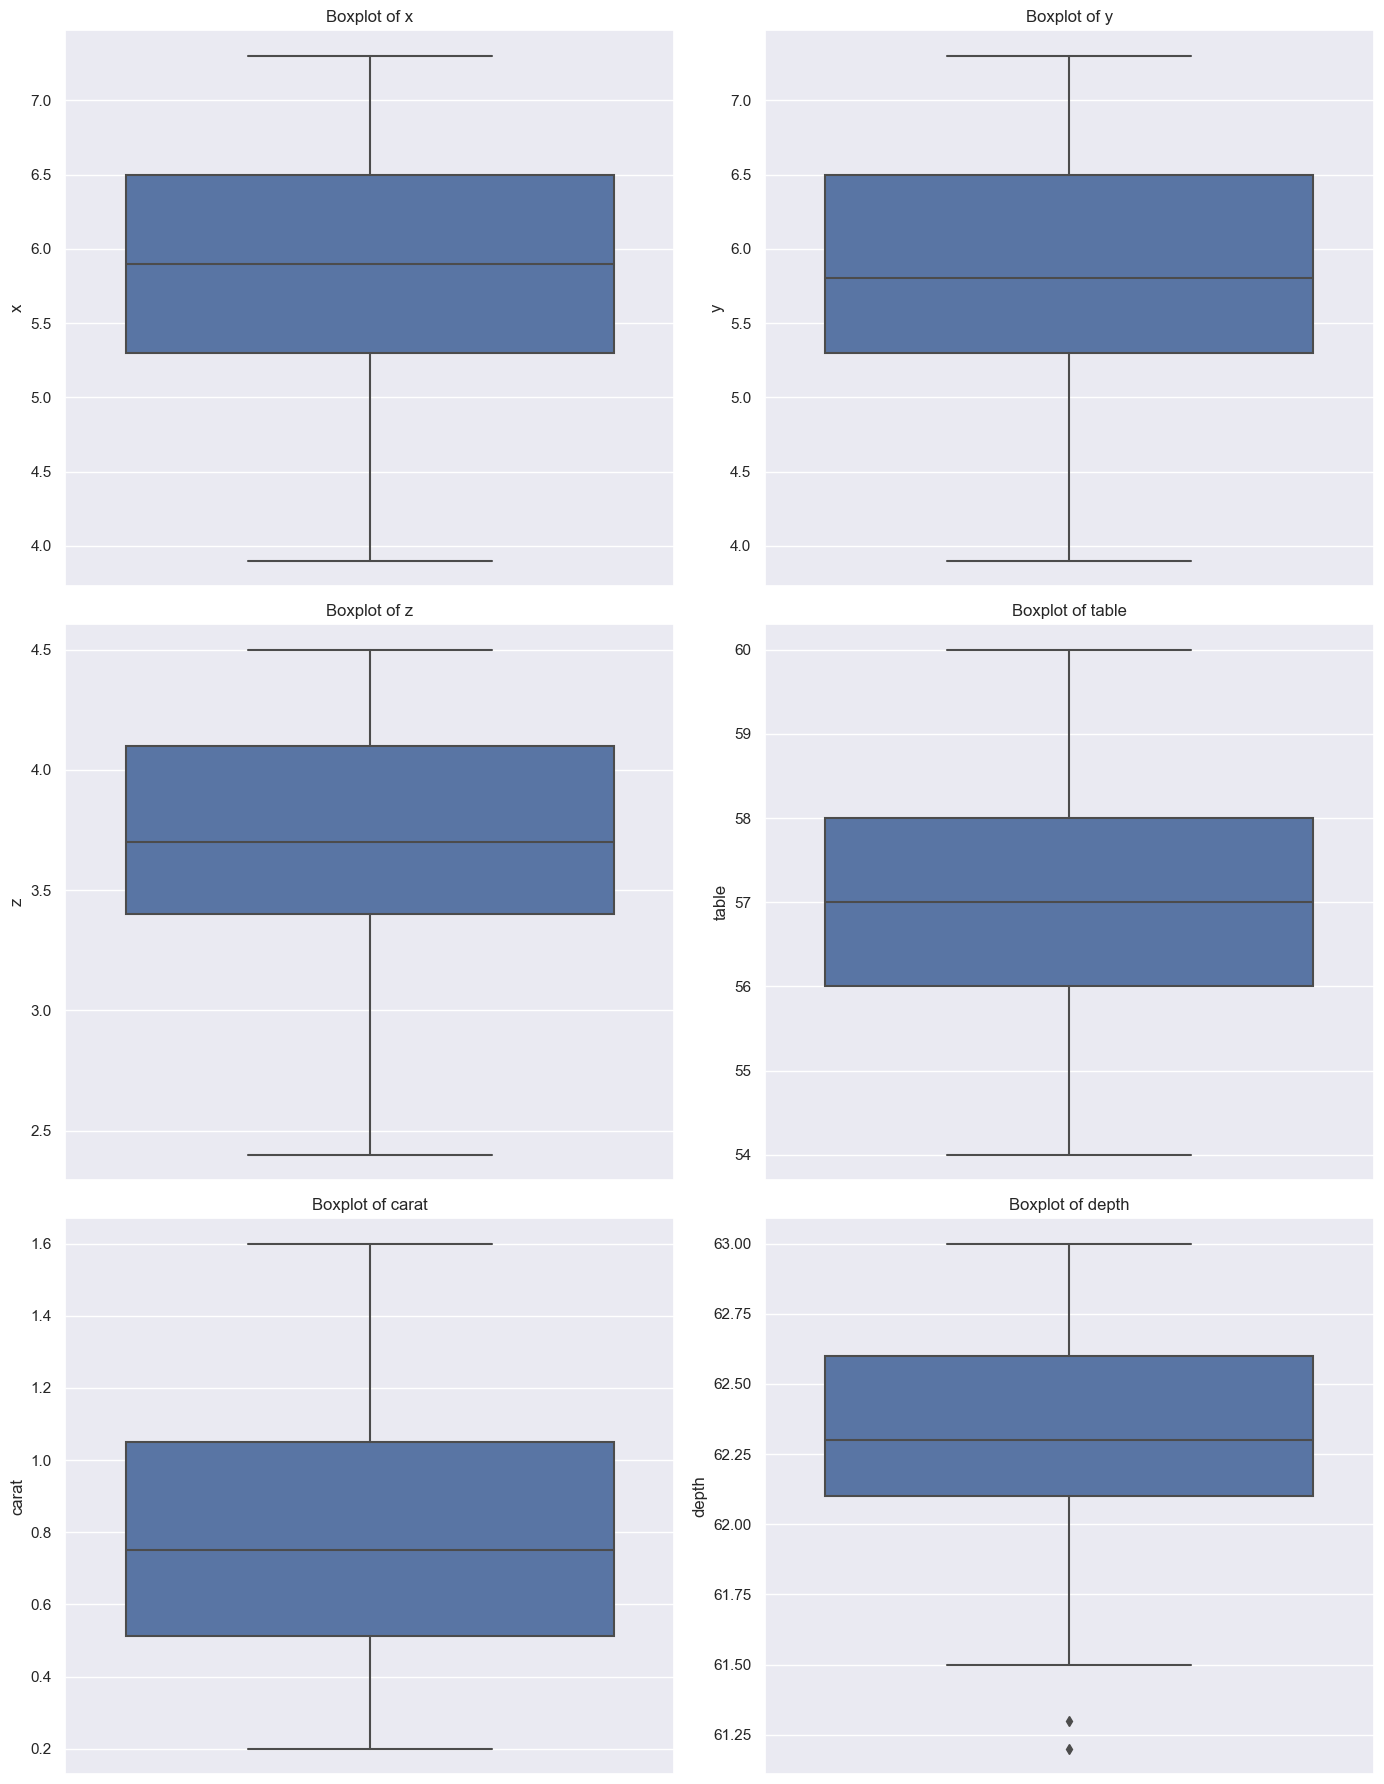

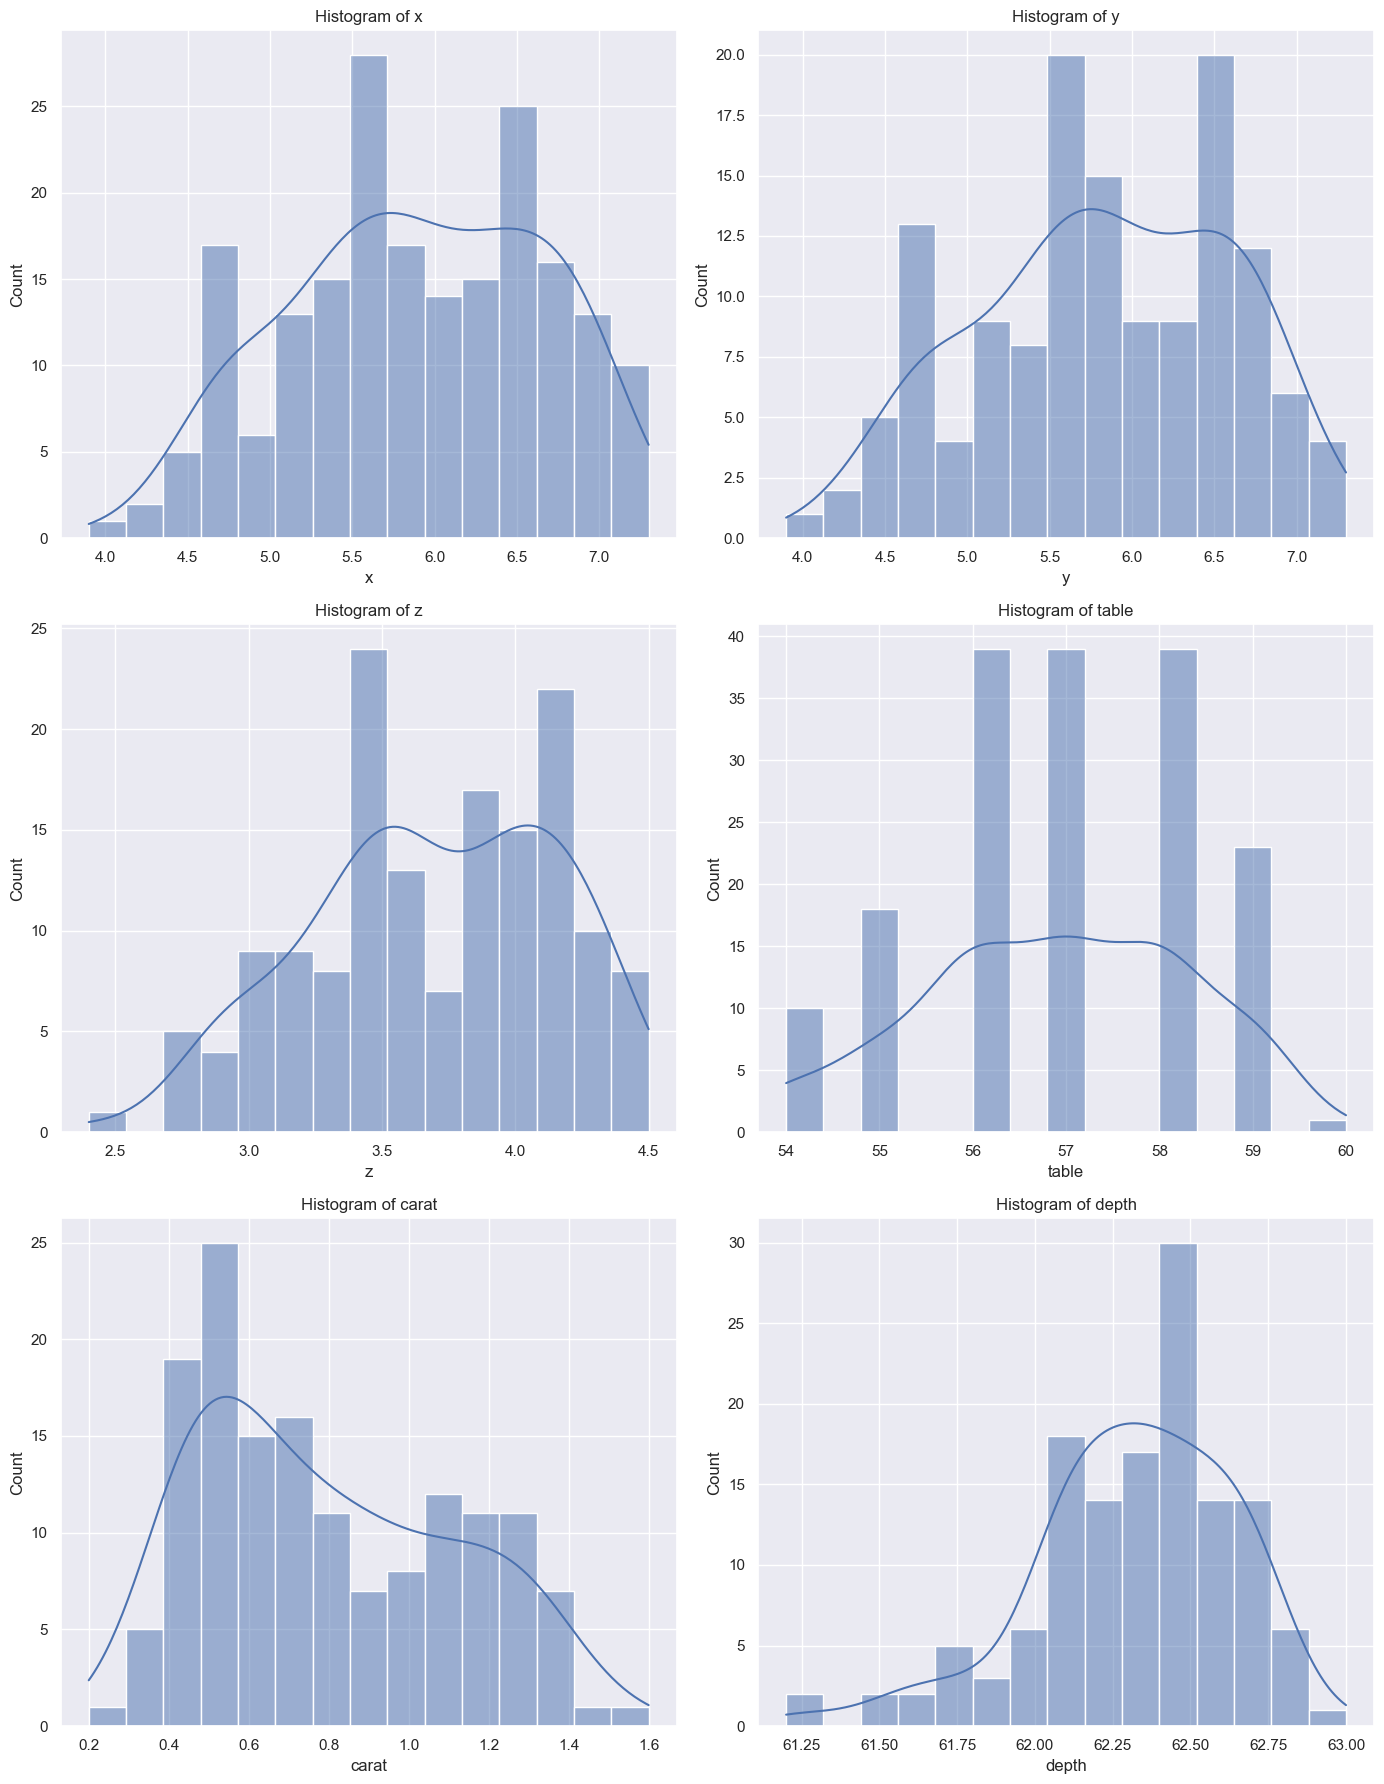

In [1320]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
variables = ['x', 'y', 'z', 'table', 'carat', 'depth']

for i, var in enumerate(variables):
    sns.boxplot(y=data[var], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Boxplot of {var}')

plt.tight_layout()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

for i, var in enumerate(variables):
    sns.histplot(x=data[var], kde=True, ax=axes[i//2, i%2], bins=15)
    axes[i//2, i%2].set_title(f'Histogram of {var}')

plt.tight_layout()
plt.show()


#### Moją początkową metodą radzenia sobie z wartościami brakującymi było zastąpienie ich średnią lub medianą. Jednak zauważyłam, że w przypadku tych zmiennych ta metoda sprawia, że uzupełnianie braków średnią/medianą zaburza rozkład zmiennych, co miałoby zły wpływ na wyniki regresji. W przypadku większości zmiennych usuwanie braków również nie wchodzi w grę - jest ich za dużo. 

#### Zdecydowałam się na zastąpienie brakujących wartości losowymi wartościmi z przedziału normalnego. Taka metoda nie zaburza rozkładów zmiennych. Jest ona również bezpieczna, ponieważ większość zmiennych, poza "price", ma niewielką skośność, można więc założyć że mają rozkład normalny. 

In [1321]:
# Oblicz średnią i odchylenie standardowe,
# Generuj losowe wartości z rozkładu normalnego o parametrach średniej i odchylenia standardowego
# Uzupełnij brakujące wartości losowymi wartościami
# Zaokrąglij wartości do dwóch miejsc po przecinku

def fill_missing_with_random_normal(data, column):
    missing_values = data[column].isnull()
    mean_value = data[column].mean()
    std_value = data[column].std()
    random_values = np.random.normal(loc=mean_value, scale=std_value, size=missing_values.sum())
    data.loc[missing_values, column] = random_values
    data[column] = round(data[column], 2)

columns_to_fill = ['x', 'y', 'z', 'table', 'depth', 'carat']

for column in columns_to_fill:
    fill_missing_with_random_normal(data, column)

In [1322]:
data.isna().sum()

carat      0
clarity    0
color      8
cut        0
x          0
y          0
z          0
depth      0
table      0
price      4
dtype: int64

#### Pozostają zmienne price i clarity. W przypadku obydwóch zmiennych wartośći brakujące stanowią niewielki procent wszystkich obserwacji, więc zdecydowałam się na usunięcie braków. 

In [1323]:
# w przypadku zmiennej 'price', tylko 4 obserwacje są nan, jest to mniej niż 10% obserwacji, więc możemy usunąć te wiersze
data['price'].isna().sum()
data = data.dropna(subset=['price'])

In [1324]:
data = data.dropna(subset=['color'])

In [1325]:
### Teraz mogę zmienić typ ceny na integer

In [1326]:
data['price'] = data['price'].astype(int)

## WARTOSCI ODSTAJACE

#### W przypadku wszystkich zmiennych zastosuję tę samą metodę usuwania wartości odstających. Usunę wszystkie wartości wychodzące poza wartość Q3 + 1,5IQR oraz Q1 - 1,5IQR.

In [1327]:
def remove_outliers(data, column):
    percentile25 = data[column].quantile(0.25)
    percentile75 = data[column].quantile(0.75)
    iqr = percentile75 - percentile25

    upper_limit = percentile75 + (1.5 * iqr)
    lower_limit = percentile25 - (1.5 * iqr)

    data = data[(data[column] <= upper_limit) & (data[column] >= lower_limit)]

    return data

columns_outliers = ['price', 'depth', 'z', 'carat', 'y','x']

for column in columns_outliers:
    data = remove_outliers(data, column)


In [1328]:
data.reset_index(drop=True, inplace=True)
data

,carat,clarity,color,cut,x,y,z,depth,table,price
0,0.70,VVS2,E,premium,5.70,5.67,3.50,62.00,59.00,4500
1,0.75,SI2,H,good,4.30,4.30,3.50,62.30,56.00,700
2,1.20,IF,D,ideal,6.57,6.80,4.20,61.70,58.00,10000
3,0.90,I1,J,fair,6.00,6.59,3.70,61.70,58.84,2400
4,0.47,SI1,G,very good,5.90,5.90,3.60,62.30,57.00,4200
...,...,...,...,...,...,...,...,...,...,...
174,0.95,SI1,G,ideal,6.40,6.40,4.00,62.34,56.00,7100
175,0.45,SI1,F,very good,4.90,4.90,2.98,62.40,59.00,2300
176,1.25,VVS2,H,good,6.90,6.01,4.30,62.65,55.00,10400
177,0.85,SI2,E,fair,6.10,6.10,3.80,62.55,58.00,6300


# REGRESJA

## Interpretacja wyników i wykresów uwzględniona w dashboardzie

C:\Users\joann\AppData\Local\Temp\ipykernel_7312\1162140176.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

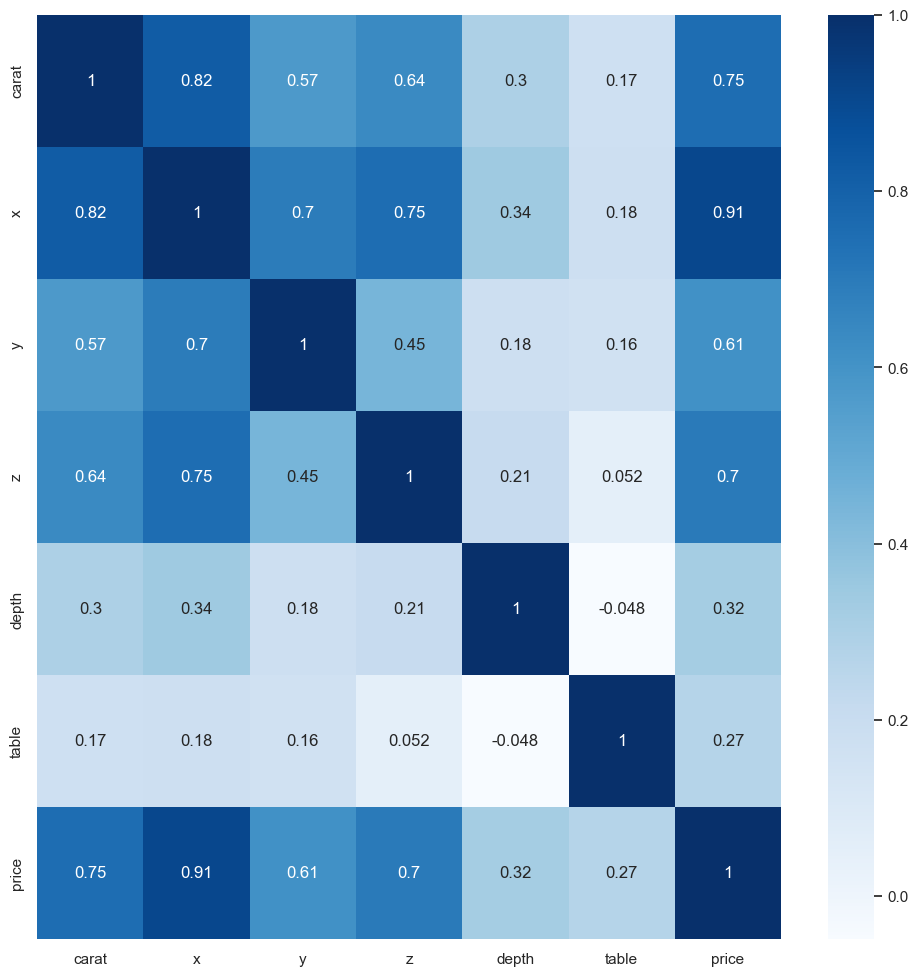

In [1329]:
cmap = sns.color_palette("Blues", as_cmap=True)
corrmat= data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

#### Zmienne clarity, colot i cut zamieniam na zmienne numeryczne, aby móc je wykorzystać w modelu. Z racji, że chcę zachować hierarchię zmiennych, nie używam LableEncoder, a przypisuję wartości ręcznie.

In [1330]:
clarity_mapping = {'IF': 7, 'VVS1': 6, 'VVS2': 5, 'VS1': 4, 'VS2': 3, 'SI1': 2, 'SI2': 1, 'I1': 0}
color_mapping = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
cut_mapping = {'ideal': 4, 'premium': 3, 'very good': 2, 'good': 1, 'fair': 0}

data['cut'] = data['cut'].map(cut_mapping)

In [1331]:
data['clarity'] = data['clarity'].map(clarity_mapping)

In [1332]:
data['color'] = data['color'].map(color_mapping)

In [1333]:
import pandas as pd
data.to_csv('C:/Users/joann/Desktop/PJATK/PAD/projektowa praca domowa/data_cleaned.csv', index=False)

In [1334]:
data.dtypes

carat      float64
clarity      int64
color        int64
cut          int64
x          float64
y          float64
z          float64
depth      float64
table      float64
price        int32
dtype: object

### Początkowy model ze wszystkimi zmiennymi

In [1344]:
import statsmodels.formula.api as smf

formula = "price ~ carat + clarity + color + cut + x + y + z + depth"
model = smf.ols(formula=formula, data=data).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     145.3
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           7.32e-72
Time:                        20:32:50   Log-Likelihood:                -1508.4
No. Observations:                 179   AIC:                             3035.
Df Residuals:                     170   BIC:                             3063.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.621e+04   2.04e+04     -1.779      0.0

### Zmienne carat i x są bardzo skorelowane między sobą oraz Z i X. WIęc usuwam Carat i Z, ponieważ X jest bardzo skorelowany z zmienną price, więc jest to pożądana sytuacja. Usuwam również table, ponieważ jest bardzo słabo skorelowana ze zmienną price.

In [1336]:
formula = "price ~ clarity + color + cut + x + y + depth"
model = smf.ols(formula=formula, data=data).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     192.7
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.30e-73
Time:                        20:32:20   Log-Likelihood:                -1509.7
No. Observations:                 179   AIC:                             3033.
Df Residuals:                     172   BIC:                             3056.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.677e+04   2.02e+04     -1.816      0.0

#### R^2 wysokie, statystyka F-statistic równiez wzrosła.

### Aby wybrać istotne zmienne w modelu używam backward selection.

In [1337]:
def backward_selection(model, p_val=0.05):
    while True:
        p_values = model.pvalues[1:]
        p_val_max = p_values.max()
        if p_val_max > p_val:
            removed_variable = p_values.idxmax()
            print(f"Removed variable: {removed_variable}")
            model = smf.ols(formula=f"{model.model.formula} - {removed_variable}", data=data).fit()
        else:
            break
    
    return model

final_model = backward_selection(model)
print(final_model.summary())


Removed variable: color
Removed variable: depth
Removed variable: y
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     381.4
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           1.71e-76
Time:                        20:32:20   Log-Likelihood:                -1511.8
No. Observations:                 179   AIC:                             3032.
Df Residuals:                     175   BIC:                             3044.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [1351]:
print("Model P Values:", model.pvalues.values)
print("Model Std Errs:", model.bse.values)
print("Model Coef:", model.params.values)

Model P Values: [7.70857129e-02 1.68799717e-01 2.01589601e-09 3.92219472e-01
 2.21490897e-03 7.49136278e-25 1.68884406e-01 4.76541007e-01
 3.19928858e-01]
Model Std Errs: [20360.23020275   484.22561821    35.84232836    52.50949546
    64.61268871   277.24655704   164.53353753   285.20799862
   328.6613915 ]
Model Coef: [-36213.55419026    669.17646618    227.17564054     45.04180328
    200.75666046   3368.61739613   -227.33197096    203.48378088
    327.84702387]


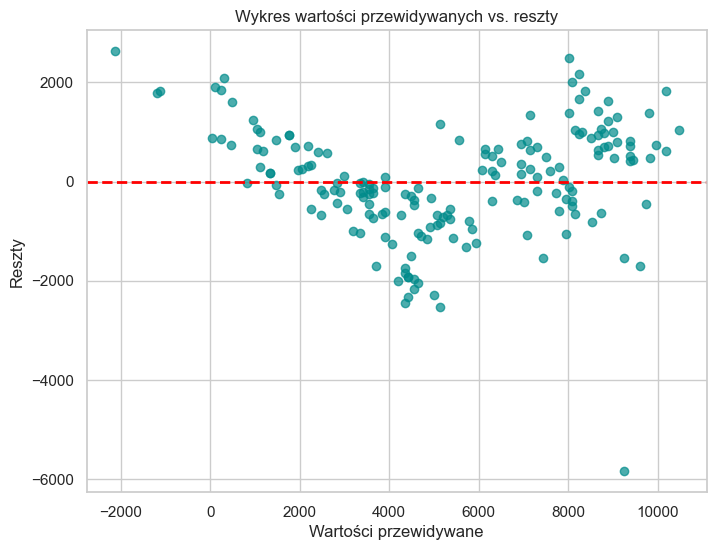

In [1352]:
import matplotlib.pyplot as plt

fitted_values = final_model.fittedvalues
residuals = final_model.resid

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
plt.scatter(fitted_values, residuals, color='darkcyan', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Wykres wartości przewidywanych vs. reszty')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.show()


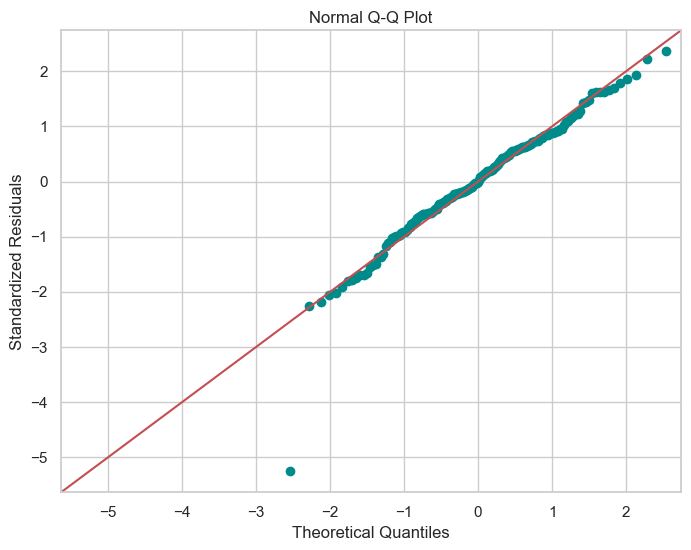

In [1353]:
fitted_values = final_model.fittedvalues
residuals = final_model.resid

standardized_residuals = final_model.get_influence().resid_studentized_internal

standardized_residuals = final_model.get_influence().resid_studentized_internal
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_theme(style="whitegrid", palette = ['darkcyan'])    
sm.qqplot(standardized_residuals, line='45', ax=ax)
ax.set_title('Normal Q-Q Plot')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Standardized Residuals')
plt.show()

Text(0, 0.5, 'Density')

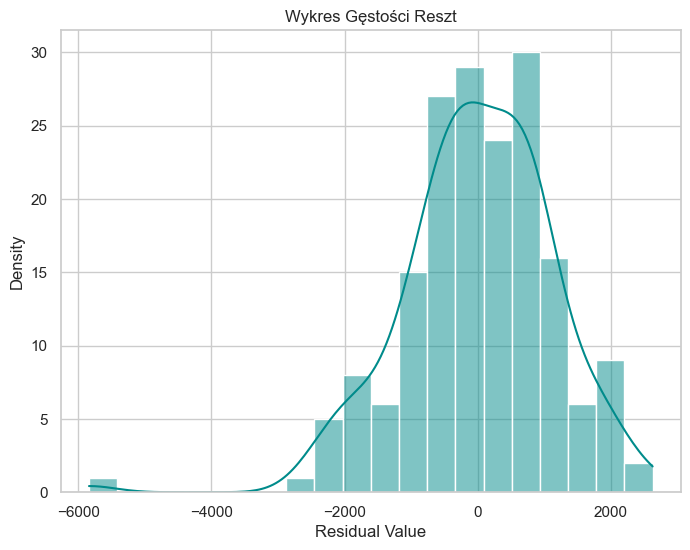

In [1355]:
residuals = final_model.resid

residuals =final_model.resid
sns.set_theme(style="whitegrid")    
fig = plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='darkcyan', bins=20)
plt.title('Wykres Gęstości Reszt')
plt.xlabel('Residual Value')
plt.ylabel('Density')

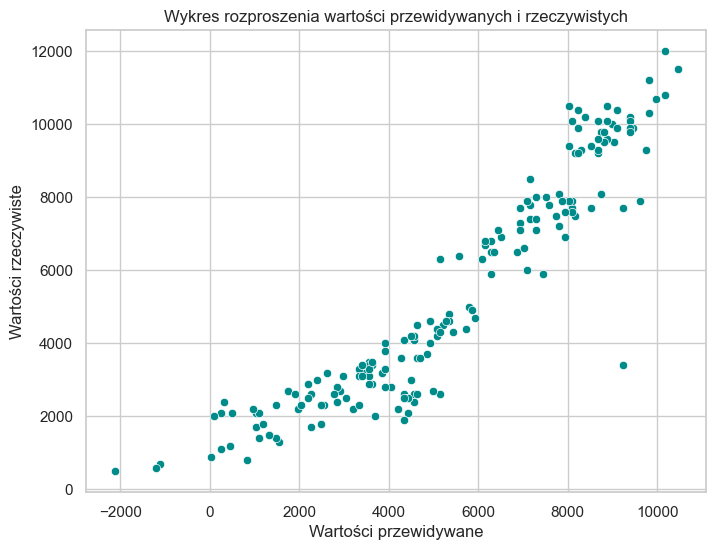

In [1357]:
fitted_values = final_model.fittedvalues
actual_values = final_model.model.endog

sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid", palette = ['darkcyan'])
sns.scatterplot(x=fitted_values, y=actual_values)
plt.title('Wykres rozproszenia wartości przewidywanych i rzeczywistych')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Wartości rzeczywiste')
plt.show()
